# Load Modules

In [41]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.metrics import precision_score , recall_score 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2
sns.set_style('whitegrid')
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def details(data_sent , comments = ''):
    if(comments):
        print(comments)
    sp = (data_sent.isna().sum().sum())/ data_sent.size
    print('________________________________________________')
    print('Sparsity in the data : {:.2f}'.format(sp))
    num_rows = data_sent.shape
    print('Data shape' , num_rows)
    #display(data_sent['class'].value_counts())
    print('Number of sources : ')
    cl = data_sent['class'].unique()
    for c in cl:
        num_src = len(data_sent[data_sent['class']==c]['src_id'].unique())
        num_obs = len(data_sent[data_sent['class']==c])
        print(c ,' \t ' , num_src , '\t' , num_obs)

# Load Data

In [43]:
from features import phot_flux , en_flux , hard, powlaw_fit , bb_fit , brems_fit , intra_obs_var , inter_ob_var , info_col , phot_flux_hilim , phot_flux_lolim , en_flux_hilim , en_flux_lolim

In [44]:
feat_to_use = info_col + phot_flux + phot_flux_hilim + phot_flux_lolim + en_flux + en_flux_hilim + en_flux_lolim + powlaw_fit +bb_fit +hard+ intra_obs_var +inter_ob_var 
data_cv = pd.read_csv('filtered_data/cv_new_data.csv' , index_col='obs_id')[feat_to_use]
data_cv.insert(0 , 'class' , ['CV']*len(data_cv))
data_pl  =  pd.read_csv('filtered_data/pulsar_new_data.csv' , index_col = 'obs_id')[feat_to_use]
data_pl.insert(0 , 'class' , ['PL']*len(data_pl))
data_lx  =  pd.read_csv('filtered_data/lmxb_data.csv' , index_col = 'obs_id')[feat_to_use]
data_lx.insert(0 , 'class' , ['LX']*len(data_lx))

In [45]:
info_col_cl =  info_col+['class']

In [5]:
# sns.histplot(data_cv['num_obs'] , color='black' , alpha = 0.3)
# sns.histplot(data_pl['num_obs'] , color='crimson' ,  alpha = 0.3)
# sns.histplot(data_lx['num_obs'] , color = 'blue' ,  alpha = 0.3)
# plt.show()

In [46]:
data = pd.concat([data_cv , data_pl , data_lx] , axis=0)
data

,class,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,...,var_inter_sigma_h,var_inter_index_m,var_inter_prob_m,var_inter_sigma_m,var_inter_index_s,var_inter_prob_s,var_inter_sigma_s,var_inter_index_u,var_inter_prob_u,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,4103.7,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_1,CV,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_2,CV,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_3,CV,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3904.6,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
CV_0_obs_4,CV,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,NaN,NaN,NaN,NaN,5.0,0.989,2.546000e-05,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LX,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMXB_90_obs_0,LX,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMXB_91_obs_0,LX,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,...,8.934000e-09,5.0,0.8,1.257000e-07,NaN,0.247,5.992000e-09,NaN,NaN,NaN


# Remove sparse columns

In [47]:
sp = [] 
for f in feat_to_use:
    #print(f)
    na = data[feat_to_use][f].isna().value_counts()
    try:
        sp.append(float(1-na[0]/(na[0]+na[1])))
    except:
        sp.append(0)
sp =  np.asarray(sp)
sparsity = pd.DataFrame(
    {
        "feat" : feat_to_use ,
        "sp_val" :sp
    }
).sort_values(by='sp_val' , ascending=False).reset_index(drop=True)
sparsity

,feat,sp_val
0,var_index_u,0.962617
1,kp_prob_u,0.889784
2,ks_prob_u,0.889784
3,var_max_u,0.889784
4,var_min_u,0.889784
...,...,...
101,dec,0.000000
102,livetime,0.000000
103,significance,0.000000
104,likelihood,0.000000


In [48]:
sparse_feat = sparsity[sparsity['sp_val']>0.5].sort_values(by='sp_val').reset_index(drop=True)
sparse_feat = sparse_feat['feat'].to_list()
#sparse_feat

In [49]:
dense_feat = sparsity[sparsity['sp_val']<0.5].sort_values(by='sp_val').reset_index(drop=True)
dense_feat = dense_feat['feat'].to_list()
#dense_feat

In [50]:
data_use = data[dense_feat+['class']]
details(data , 'Before removing sparse columns')
details(data_use , 'After removing sparse columns')

Before removing sparse columns
________________________________________________
Sparsity in the data : 0.44
Data shape (3103, 107)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521
After removing sparse columns
________________________________________________
Sparsity in the data : 0.21
Data shape (3103, 59)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521


## Take log

In [51]:
flux_feat = phot_flux + phot_flux_lolim + phot_flux_hilim + en_flux + en_flux_lolim + en_flux_hilim
flux_feat_avail = list(set(flux_feat) & set(dense_feat))
def take_log(data_sent):
    x_train_log = data_sent.copy()
    for f in flux_feat_avail[:]:
        x_train_log.loc[:,f] = -(np.log10(x_train_log.loc[:,f]))
    x_train_log = x_train_log.replace(-np.inf , np.nan)
    x_train_log = x_train_log.replace(np.inf , np.nan)
    return x_train_log


## Take Log of flux columns

In [52]:
df_log = take_log(data_use)
details(df_log)

________________________________________________
Sparsity in the data : 0.21
Data shape (3103, 59)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521


# all-obs imputation

## Impute entire dataset

In [53]:
data_id = df_log[info_col_cl]
data_val = df_log.drop(columns = info_col_cl)
rf_imputer = MissForest(verbose=0 , decreasing=True)
new_data = rf_imputer.fit_transform(data_val)

Iteration: 0


In [15]:
new_imp_data =  pd.DataFrame(new_data , columns = data_val.columns.to_list()  , index=data_val.index.to_list())
new_imp_data.index.name = 'obs_id'

In [16]:
data_imp_v2 = pd.concat([data_id , new_imp_data] , axis=1)
data_imp_v2

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,4103.7,52.93,16618.73000,CV,...,0.78804,0.007736,0.001581,0.002353,0.001660,0.83206,0.56187,5.0,3.16,0.000574
CV_0_obs_1,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,CV,...,0.80924,0.006894,0.001942,0.002431,0.001217,0.78013,0.55582,5.0,3.16,0.000609
CV_0_obs_2,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,CV,...,0.77429,0.007146,0.001776,0.002405,0.001292,0.79490,0.56132,5.0,3.16,0.000603
CV_0_obs_3,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3904.6,52.93,16618.73000,CV,...,0.78813,0.004996,0.001706,0.002359,0.000885,0.79146,0.58881,5.0,3.16,0.000584
CV_0_obs_4,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,CV,...,0.73832,0.006301,0.001968,0.002552,0.001035,0.78198,0.54714,5.0,3.16,0.000603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,LX,...,0.53900,0.003494,0.003420,0.003456,0.000029,0.82900,0.08400,5.0,3.14,0.000019
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,LX,...,0.21100,0.003517,0.001060,0.001171,0.000255,0.26500,0.80700,5.0,3.16,0.000208
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,LX,...,0.54700,0.002756,0.001488,0.001623,0.000211,0.73500,0.45100,3.0,5.00,0.000001


In [17]:
data_imp_v2.to_csv('imputed_data/new-data-all-at-once-imp.csv')

In [18]:
data_imp_v2 = pd.read_csv('imputed_data/new-data-all-at-once-imp.csv' , index_col='obs_id')

In [19]:
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (3103, 59)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521


In [20]:
data_id = data_imp_v2[info_col]
data_label = data_imp_v2['class']
data_val = data_imp_v2.drop(columns=['class']+info_col)

# Combine Obs

In [21]:

df_comb = pd.DataFrame()
for s in data_imp_v2['src_id'].unique()[:]:
    temp = data_imp_v2[data_imp_v2['src_id']==s]
    temp_id =  temp[info_col_cl]
    temp_val = temp.drop(columns=info_col_cl)
    temp_mean = temp_val.mean().to_frame().T
    temp_id_top = temp_id.iloc[0:1].reset_index()
    temp_final = pd.concat([temp_id_top , temp_mean] , axis=1).set_index('obs_id')
    df_comb = df_comb.append(temp_final)
display(df_comb)


,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.755380,0.007482,0.002113,0.002874,0.001237,0.787332,0.556167,5.0,3.171667,5.451985e-04
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.639068,0.003761,0.001431,0.002125,0.000599,0.624043,0.581713,5.0,3.000000,9.789000e-07
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.678273,0.004365,0.001637,0.001989,0.000528,0.646464,0.528185,3.0,4.000000,1.081000e-06
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,0.360121,0.005032,0.003386,0.003724,0.000373,0.383937,0.229635,6.0,8.000000,7.858000e-07
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.728138,0.005160,0.002734,0.003270,0.000602,0.601925,0.549929,3.0,4.000000,1.098000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,0.539000,0.003494,0.003420,0.003456,0.000029,0.829000,0.084000,5.0,3.140000,1.943669e-05
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,0.211000,0.003517,0.001060,0.001171,0.000255,0.265000,0.807000,5.0,3.160000,2.078784e-04
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,0.547000,0.002756,0.001488,0.001623,0.000211,0.735000,0.451000,3.0,5.000000,1.002555e-06


# Normalize

In [403]:
#data_imp_norm.to_csv('all_filled_norm.csv')

In [43]:
#data_imp_v2 = pd.read_csv('imputed_data/srcwise-imp_old-data.csv' , index_col = 'obs_id')

In [22]:
data_id = df_comb[info_col]
data_label = df_comb['class']
data_val = df_comb.drop(columns=['class']+info_col)
data_imp_norm = df_comb.copy()
for c in data_val.columns.to_list():
    data_imp_norm.loc[:,c] = (data_imp_norm.loc[:,c] - data_imp_norm.loc[:,c].mean()) / data_imp_norm.loc[:,c].std()
data_imp_norm

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.790279,-0.209045,-0.420496,-0.416043,0.061828,0.904661,0.620586,0.201481,-0.723339,0.169104
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.288265,-0.429529,-0.478241,-0.473577,-0.144986,0.199352,0.729291,0.201481,-0.815152,-0.097884
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.457474,-0.393739,-0.460802,-0.484026,-0.168108,0.296195,0.501519,-0.947653,-0.280317,-0.097833
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,-0.915698,-0.354258,-0.312784,-0.350698,-0.218404,-0.837763,-0.768857,0.776049,1.859022,-0.097978
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.672697,-0.346645,-0.367941,-0.385637,-0.144255,0.103816,0.594044,-0.947653,-0.280317,-0.097825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,-0.143639,-0.445371,-0.309876,-0.371319,-0.330093,1.084642,-1.388558,0.201481,-0.740275,-0.088828
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,-1.559317,-0.444008,-0.509596,-0.546835,-0.256608,-1.351499,1.687921,0.201481,-0.729578,0.003619
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,-0.109110,-0.489102,-0.473376,-0.512116,-0.270907,0.678618,0.173085,-0.947653,0.254518,-0.097872


In [23]:
details(data_imp_norm)

________________________________________________
Sparsity in the data : 0.00
Data shape (420, 59)
Number of sources : 
CV  	  184 	 184
PL  	  178 	 178
LX  	  58 	 58


In [36]:
verbose = 1
val_acc = []
test_acc = []
for i in tqdm(range(10)):
    src_list = pd.DataFrame()
    class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_norm.copy()
    for cl in class_to_select:
        src = df[df['class']==cl]['src_id'].value_counts().sort_values()
        #display(src)
        src = src.iloc[:int(len(src)*0.3)]
        src_select = src.sample(frac=0.8)
        src_id = src_select.index.to_list()
        src_obs = src_select.to_list()
        temp_src = pd.DataFrame({ 
            'src_id' : src_id , 
            'obs_count' : src_obs
        })
        src_list = src_list.append(temp_src)
    #src_list

    all_src = np.unique(df['src_id'].to_list())
    test_src = src_list['src_id'].to_list()
    train_src= list(set(all_src) - set(src_list['src_id']))
    # if(verbose):
    #     print('Total Number of ssources :' , len(all_src))
    #     print('Training_sources : ' , len(train_src) )
    #     print('Validation sources :' , len(test_src))

    # df = df.replace({
    #     "BH" :2 , 
    #     "NS" : 2 ,
    #     "CV" : 0 , 
    #     "PULSAR" : 1 
    # })


    df= df[df['class'].isin(class_to_select)]
    df 



    df_train  = df[df['src_id'].isin(train_src)]
    df_test = df[df['src_id'].isin(test_src)]

    df_train = df_train[df_train['class'].isin(class_to_select)]
    df_test = df_test[df_test['class'].isin(class_to_select)]

    if(verbose):
        details(df_train)
        details(df_test)

    train_id = df_train[info_col]
    train_label = df_train['class']
    train_value = df_train.drop(columns=['class']+info_col)


    i_val = df_test[info_col]
    y_val = df_test['class']
    x_val = df_test.drop(columns=['class']+info_col)

    clf = RandomForestClassifier(
        n_estimators = 400 , n_jobs=-1 , 
        class_weight='balanced'
    )
    #clf = AdaBoostClassifier(base_estimator=clf ,)
    #clf = xgb.XGBRFClassifier(n_componets=200)
    #clf = xgb.XGBClassifier()
    #x_train , x_test , y_train , y_test = train_test_split(train_value , train_label , test_size=0.1 , stratify=train_label, random_state=9)
    x_train , y_train = train_value , train_label
    clf.fit(x_train , y_train)
    v_sc = clf.score(x_val , y_val)
    test_sc = clf.score(x_train, y_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    print(test_sc , v_sc)

  0%|          | 0/10 [00:00<?, ?it/s]

________________________________________________
Sparsity in the data : 0.00
Data shape (320, 59)
Number of sources : 
CV  	  140 	 140
PL  	  136 	 136
LX  	  44 	 44
________________________________________________
Sparsity in the data : 0.00
Data shape (100, 59)
Number of sources : 
CV  	  44 	 44
PL  	  42 	 42
LX  	  14 	 14


 10%|█         | 1/10 [00:01<00:13,  1.50s/it]

0.984375 0.67
________________________________________________
Sparsity in the data : 0.00
Data shape (320, 59)
Number of sources : 
CV  	  140 	 140
PL  	  136 	 136
LX  	  44 	 44
________________________________________________
Sparsity in the data : 0.00
Data shape (100, 59)
Number of sources : 
CV  	  44 	 44
PL  	  42 	 42
LX  	  14 	 14


 20%|██        | 2/10 [00:02<00:11,  1.50s/it]

0.984375 0.7
________________________________________________
Sparsity in the data : 0.00
Data shape (320, 59)
Number of sources : 
CV  	  140 	 140
PL  	  136 	 136
LX  	  44 	 44
________________________________________________
Sparsity in the data : 0.00
Data shape (100, 59)
Number of sources : 
CV  	  44 	 44
PL  	  42 	 42
LX  	  14 	 14


 30%|███       | 3/10 [00:04<00:09,  1.43s/it]

0.9875 0.65
________________________________________________
Sparsity in the data : 0.00
Data shape (320, 59)
Number of sources : 
CV  	  140 	 140
PL  	  136 	 136
LX  	  44 	 44
________________________________________________
Sparsity in the data : 0.00
Data shape (100, 59)
Number of sources : 
CV  	  44 	 44
PL  	  42 	 42
LX  	  14 	 14


 40%|████      | 4/10 [00:05<00:07,  1.31s/it]

0.9875 0.7
________________________________________________
Sparsity in the data : 0.00
Data shape (320, 59)
Number of sources : 
CV  	  140 	 140
PL  	  136 	 136
LX  	  44 	 44
________________________________________________
Sparsity in the data : 0.00
Data shape (100, 59)
Number of sources : 
CV  	  44 	 44
PL  	  42 	 42
LX  	  14 	 14


 50%|█████     | 5/10 [00:06<00:06,  1.24s/it]

0.9875 0.72
________________________________________________
Sparsity in the data : 0.00
Data shape (320, 59)
Number of sources : 
CV  	  140 	 140
PL  	  136 	 136
LX  	  44 	 44
________________________________________________
Sparsity in the data : 0.00
Data shape (100, 59)
Number of sources : 
CV  	  44 	 44
PL  	  42 	 42
LX  	  14 	 14


 60%|██████    | 6/10 [00:07<00:05,  1.27s/it]

0.9875 0.71
________________________________________________
Sparsity in the data : 0.00
Data shape (320, 59)
Number of sources : 
CV  	  140 	 140
PL  	  136 	 136
LX  	  44 	 44
________________________________________________
Sparsity in the data : 0.00
Data shape (100, 59)
Number of sources : 
CV  	  44 	 44
PL  	  42 	 42
LX  	  14 	 14


 70%|███████   | 7/10 [00:09<00:03,  1.25s/it]

0.98125 0.65
________________________________________________
Sparsity in the data : 0.00
Data shape (320, 59)
Number of sources : 
CV  	  140 	 140
PL  	  136 	 136
LX  	  44 	 44
________________________________________________
Sparsity in the data : 0.00
Data shape (100, 59)
Number of sources : 
CV  	  44 	 44
PL  	  42 	 42
LX  	  14 	 14


 80%|████████  | 8/10 [00:10<00:02,  1.27s/it]

0.9875 0.7
________________________________________________
Sparsity in the data : 0.00
Data shape (320, 59)
Number of sources : 
CV  	  140 	 140
PL  	  136 	 136
LX  	  44 	 44
________________________________________________
Sparsity in the data : 0.00
Data shape (100, 59)
Number of sources : 
CV  	  44 	 44
PL  	  42 	 42
LX  	  14 	 14


 90%|█████████ | 9/10 [00:11<00:01,  1.20s/it]

0.9875 0.72
________________________________________________
Sparsity in the data : 0.00
Data shape (320, 59)
Number of sources : 
CV  	  140 	 140
PL  	  136 	 136
LX  	  44 	 44
________________________________________________
Sparsity in the data : 0.00
Data shape (100, 59)
Number of sources : 
CV  	  44 	 44
PL  	  42 	 42
LX  	  14 	 14


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]

0.98125 0.61


In [39]:
df_train.columns.to_list()

['src_id',
 'num_obs',
 'src_n',
 'name',
 'ra',
 'dec',
 'livetime',
 'significance',
 'likelihood',
 'class',
 'photflux_aper_hilim_b',
 'photflux_aper_hilim_m',
 'photflux_aper_hilim_h',
 'flux_aper_hilim_b',
 'photflux_aper_hilim_s',
 'hard_hm',
 'hard_hs',
 'hard_ms',
 'flux_aper_hilim_s',
 'flux_aper_hilim_m',
 'flux_aper_hilim_h',
 'var_inter_sigma_b',
 'var_inter_prob_b',
 'photflux_aper_hilim_u',
 'var_inter_sigma_m',
 'var_inter_prob_m',
 'var_inter_prob_s',
 'var_inter_sigma_s',
 'photflux_aper_b',
 'var_inter_sigma_h',
 'var_inter_index_b',
 'var_inter_prob_h',
 'flux_aper_b',
 'photflux_aper_lolim_b',
 'flux_aper_lolim_b',
 'photflux_aper_m',
 'flux_aper_m',
 'photflux_aper_h',
 'photflux_aper_lolim_m',
 'flux_aper_h',
 'photflux_aper_lolim_h',
 'photflux_aper_s',
 'flux_aper_lolim_m',
 'flux_aper_hilim_u',
 'flux_aper_lolim_h',
 'flux_aper_s',
 'var_inter_index_h',
 'photflux_aper_lolim_s',
 'flux_aper_lolim_s',
 'kp_prob_b',
 'var_max_b',
 'var_min_b',
 'var_mean_b',
 'v

In [37]:
score = pd.DataFrame({
    "Test Score" : test_acc, 
    "Validation Score" : val_acc
})*100
score.describe().loc[['mean' , 'std' , 'min', 'max' ]]

,Test Score,Validation Score
mean,98.562500,68.300000
std,0.263523,3.653005
min,98.125000,61.000000
max,98.750000,72.000000


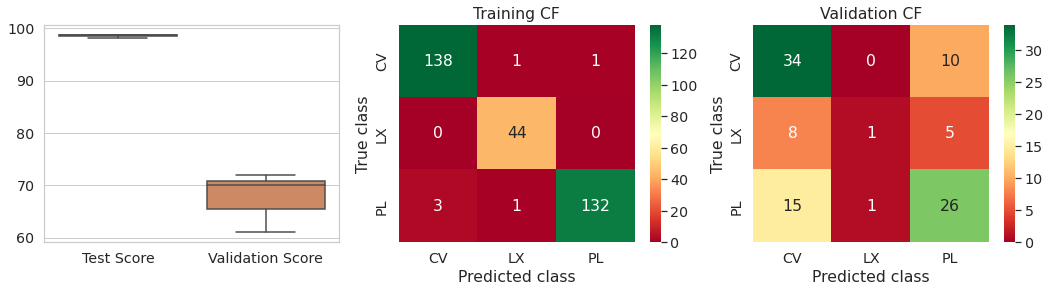

In [38]:
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols=3 , figsize = (18 , 4))
sns.boxplot(data = score , ax = ax[0])
cf = confusion_matrix(y_train , clf.predict(x_train) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[1] , xticklabels =class_to_select , yticklabels = class_to_select  , cmap='RdYlGn' ,)
cf = confusion_matrix(y_val , clf.predict(x_val) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[2] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='RdYlGn')
ax[1].set_title('Training CF')
ax[2].set_title('Validation CF')
for a in ax[1:]:
    a.set_xlabel('Predicted class')
    a.set_ylabel('True class')

plt.show()
#score

In [79]:
y_true , y_pred = y_val , clf.predict(x_val)


In [80]:
y_pred_prob = clf.predict_proba(x_val)

In [81]:
from sklearn.metrics import precision_score , recall_score , roc_auc_score

,type,CV,LX,PL
0,Precision,0.600000,0.375,0.709677
1,Recall,0.428571,0.400,0.916667


<AxesSubplot:xlabel='variable', ylabel='value'>

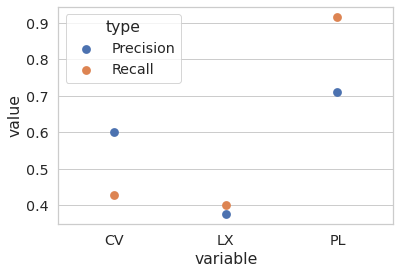

In [114]:

ps = precision_score(y_true , y_pred , average=None)
rc = recall_score(y_true , y_pred , average=None)
#auc = roc_auc_score(y_val_oh , y_pred_prob)
sc = pd.DataFrame(
    np.asarray([ps , rc]) , columns=['CV' , 'LX' , 'PL'] , index=['Precision' , 'Recall']
)
sc.index.name = 'type'
sc =sc.reset_index()
display(sc)
sc = sc.melt(id_vars=['type'] , value_vars = ['CV' , 'LX' , 'PL'])
sns.pointplot(
    data = sc , x = 'variable' , y = 'value' , hue = 'type' , join=False , ax=ax[3]
)

In [391]:
pd.DataFrame({
    'feat' : x_train.columns.to_list() , 
    'val' : clf.feature_importances_
}).sort_values('val' , ascending=False).reset_index(drop=True)

,feat,val
0,photflux_aper_m,0.149696
1,var_inter_prob_m,0.135717
2,flux_aper_m,0.081213
3,var_inter_sigma_h,0.063748
4,var_inter_prob_s,0.054214
5,var_inter_index_h,0.043667
6,var_inter_sigma_m,0.042827
7,var_inter_sigma_b,0.036619
8,var_min_b,0.033070
9,var_inter_prob_b,0.032857
